In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from sklearn.decomposition import PCA
from scdna_replication_tools.plot_utils import get_rt_cmap, get_clone_cmap, get_phase_cmap, format_embedding_frame, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix

In [32]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load data and create functions for plotting the reads per million, hmmcopy states, PERT CN, and PERT replciation states for G1/2 and S-phase cells of representative dataset SA1292.

In [17]:
dataset = 'SA1292'

cn_s = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/s_phase_cells_with_scRT_filtered.tsv'.format(dataset), sep='\t')
cn_g = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/g1_phase_cells_with_scRT_filtered.tsv'.format(dataset), sep='\t')

# convert the 'chr' column to dtype string then categorical
cn_s['chr'] = cn_s['chr'].astype(str).astype('category')
cn_g['chr'] = cn_g['chr'].astype(str).astype('category')

cn_s.shape, cn_g.shape

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


((1940556, 44), (4627899, 44))

In [18]:
cn_g.columns

Index(['chr', 'start', 'end', 'cell_id', 'reads', 'gc', 'map', 'copy', 'state',
       'total_mapped_reads_hmmcopy', 'experimental_condition', 'is_s_phase',
       'is_s_phase_prob', 'multiplier', 'quality', 'is_contaminated',
       'cell_call', 'fastqscreen_grch37', 'fastqscreen_mm10', 'coverage_depth',
       'breakpoints', 'library_id', 'rpm', 'in_tree', 'clone_id', 'madn',
       'lrs', 'corrected_madn', 'corrected_breakpoints', 'assigned_clone_id',
       'model_cn_state', 'model_rep_state', 'model_tau', 'model_u',
       'model_rho', 'extreme_cell_frac', 'cell_frac_rep', 'rpm_auto',
       'rep_auto', 'cn_bk', 'rep_bk', 'frac_cn0', 'rpm_auto_norm',
       'rep_auto_norm'],
      dtype='object')

In [23]:
def plot_pert_cn_rep_heatmaps(
    cn_s, cn_g, 
    ax_rpm_s, ax_rpm_g, ax_hmm_s, ax_hmm_g,
    ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g,
    ax_clone_s, ax_clone_g, ax_time_s, ax_time_g,
    clone_col='clone_id', second_sort_col='cell_frac_rep',
    rpm_col='rpm', hmmcopy_col='state',
    pert_cn_col='model_cn_state', pert_rep_col='model_rep_state',
    rt_cmap=get_rt_cmap(), clone_cmap=get_clone_cmap(),
    chrom_labels_to_remove=[], dataset='SA1292'
    ):
    ''' 
    Plot PERT output heatmaps for S-phase and G1/2-phase cells. 
    
    Parameters
    ----------
    cn_s : pandas.DataFrame
        long-form dataframe of S-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    cn_g : pandas.DataFrame
        long-form dataframe of G1/2-phase cells with pert model results.
        this dataframe should have the following columns in addition to those specified by additional parameters:
            - chr (categorical)
            - start (int)
            - end (int)
            - cell_id (str)
    ax_rpm_s : matplotlib.axes.Axes
        axes for the S-phase reads per million heatmap
    ax_rpm_g : matplotlib.axes.Axes
        axes for the G1/2-phase reads per million heatmap
    ax_hmm_s : matplotlib.axes.Axes
        axes for the S-phase HMMCopy state heatmap
    ax_hmm_g : matplotlib.axes.Axes
        axes for the G1/2-phase HMMCopy state heatmap
    ax_cn_s : matplotlib.axes.Axes
        axes for the S-phase PERT CN heatmap
    ax_cn_g : matplotlib.axes.Axes
        axes for the G1/2-phase PERT CN heatmap
    ax_rep_s : matplotlib.axes.Axes
        axes for the S-phase replication state heatmap
    ax_rep_g : matplotlib.axes.Axes
        axes for the G1/2-phase replication state heatmap
    ax_clone_s : matplotlib.axes.Axes
        axes for the S-phase clone ID colorbar annotations
    ax_clone_g : matplotlib.axes.Axes
        axes for the G1/2-phase clone ID colorbar annotations
    ax_time_s : matplotlib.axes.Axes
        axes for the S-phase time colorbar annotations
    ax_time_g : matplotlib.axes.Axes
        axes for the G1/2-phase time colorbar annotations
    clone_col : str
        column name for clone IDs
    second_sort_col : str
        column name for secondary sorting of cells (e.g. time in S-phase)
    rpm_col : str
        column name for reads per million
    hmmcopy_col : str
        column name for HMMCopy states
    pert_cn_col : str
        column name for output CN states (from pert)
    pert_rep_col : str
        column name for output replication states (from pert)
    rt_cmap : matplotlib.colors.ListedColormap
        colormap for replication states
    clone_cmap : matplotlib.colors.ListedColormap
        colormap for clone IDs
    chrom_labels_to_remove : list
        chromosomes to remove from x-axis to avoid crowding
    '''

    # create mapping of clone IDs
    cluster_col = 'cluster_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(cn_g[clone_col].unique()))])
    cn_g[cluster_col] = cn_g[clone_col]
    cn_g = cn_g.replace({cluster_col: clone_dict})
    cn_s[cluster_col] = cn_s[clone_col]
    cn_s = cn_s.replace({cluster_col: clone_dict})

    # plot the reads per million for the S-phase cells
    plot_data_rpm_s = plot_clustered_cell_cn_matrix(
        ax_rpm_s, cn_s, rpm_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col,
        cmap='viridis', chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove, max_cn=None, raw=True
    )

    # plot the reads per million for the G1/2-phase cells
    plot_data_rpm_g = plot_clustered_cell_cn_matrix(
        ax_rpm_g, cn_g, rpm_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col,
        cmap='viridis', chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove, max_cn=None, raw=True
    )

    # plot the HMMCopy states for the S-phase cells
    plot_data_hmm_s = plot_clustered_cell_cn_matrix(
        ax_hmm_s, cn_s, hmmcopy_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col,
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the HMMCopy states for the G1/2-phase cells
    plot_data_hmm_g = plot_clustered_cell_cn_matrix(
        ax_hmm_g, cn_g, hmmcopy_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col,
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the CN states for the S-phase cells
    plot_data_cn_s = plot_clustered_cell_cn_matrix(
        ax_cn_s, cn_s, pert_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, 
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the S-phase cells
    plot_data_rep_s = plot_clustered_cell_cn_matrix(
        ax_rep_s, cn_s, pert_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, 
        cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the CN states for the G1/2-phase cells
    plot_data_cn_g = plot_clustered_cell_cn_matrix(
        ax_cn_g, cn_g, pert_cn_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, 
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # plot the replication states for the G1/2-phase cells
    plot_data_rep_g = plot_clustered_cell_cn_matrix(
        ax_rep_g, cn_g, pert_rep_col, cluster_field_name=cluster_col, secondary_field_name=second_sort_col, 
        cmap=rt_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )

    # turn off the y-axis ticks in all subplots
    for ax in [ax_rpm_s, ax_rpm_g, ax_hmm_s, ax_hmm_g, ax_cn_s, ax_cn_g, ax_rep_s, ax_rep_g, ax_clone_s, ax_clone_g, ax_time_s, ax_time_g]:
        ax.set_yticks([])
        ax.set_ylabel('')

    # add the colorbars for clone_id and model_tau
    if len(clone_dict) > 1:
        cell_ids_g = plot_data_cn_g.columns.get_level_values(0).values
        cluster_ids_g = plot_data_cn_g.columns.get_level_values(1).values
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat_g, _ = cncluster.get_cluster_colors(cluster_ids_g, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_g = cn_g[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_g = []
        for cell in cell_ids_g:
            g = condensed_cn_g[condensed_cn_g['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_g.append(g)

        # make color mat according to secondary array
        secondary_color_mat_g, _ = make_color_mat_float(secondary_array_g, 'Blues')

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_g, color_mat_g)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_g, secondary_color_mat_g)

        # repeat for the S-phase cells
        cell_ids_s = plot_data_cn_s.columns.get_level_values(0).values
        cluster_ids_s = plot_data_cn_s.columns.get_level_values(1).values
        color_mat_s, _ = cncluster.get_cluster_colors(cluster_ids_s, color_map=clone_cmap, return_map=True)

        # get array of second_sort_col values that that match the cell_id order
        condensed_cn_s = cn_s[['cell_id', second_sort_col]].drop_duplicates()
        secondary_array_s = []
        for cell in cell_ids_s:
            s = condensed_cn_s[condensed_cn_s['cell_id'] == cell][second_sort_col].values[0]
            secondary_array_s.append(s)
        
        # make color mat according to secondary array
        secondary_color_mat_s, _ = make_color_mat_float(secondary_array_s, 'Blues')

        # create color bar that shows clone id for each row in heatmap
        plot_colorbar(ax_clone_s, color_mat_s)

        # create color bar that shows secondary sort value for each row in heatmap
        plot_colorbar(ax_time_s, secondary_color_mat_s)
    
    # add 'chromosome' x-axis label to the heatmaps
    for ax in [ax_rpm_g, ax_hmm_g, ax_cn_g, ax_rep_g]:
        ax.set_xlabel('chromosome')
    
    ax_clone_g.set_ylabel('{} PERT G1/2-phase cells'.format(len(cn_g.cell_id.unique())))
    ax_clone_s.set_ylabel('{} PERT S-phase cells'.format(len(cn_s.cell_id.unique())))

    # add x-axis ticklabels to the ax_clone and ax_time colorsbars
    ax_clone_g.set_xticks([0.0])
    ax_clone_g.set_xticklabels(['clone'], rotation=90)
    ax_time_g.set_xticks([0.0])
    ax_time_g.set_xticklabels(['time'], rotation=90)

    # set titles for each column
    ax_rpm_s.set_title('Reads per million\n{} S-phase cells'.format(dataset))
    ax_hmm_s.set_title('HMMcopy states\n{} S-phase cells'.format(dataset))
    ax_cn_s.set_title('PERT somatic CN states\n{} S-phase cells'.format(dataset))
    ax_rep_s.set_title('PERT replication states\n{} S-phase cells'.format(dataset))
    for ax in [ax_rpm_g, ax_hmm_g, ax_cn_g, ax_rep_g]:
        ax.set_title('{} G1/2-phase cells'.format(dataset))


### Load data and create functions for plotting the SA1292 PERT vs Laks phase confusion matrix and violinplots of orthogonal cell cycle features.

In [26]:
cn_lowqual = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/model_lowqual_cells.tsv'.format(dataset), sep='\t')

# compute the ploidy and gc bias coefficients for each cell
for cn in [cn_g, cn_s, cn_lowqual]:
    for cell_id, cell_cn in cn.groupby('cell_id'):
        # ploidy is the modal state
        cn.loc[cn.cell_id == cell_id, 'ploidy'] = cell_cn.state.value_counts().index[0]

        # fit a 1st order polynomial to rpm vs gc
        gc_fit = np.polyfit(cell_cn.gc, cell_cn.rpm, 1)
        cn.loc[cn.cell_id == cell_id, 'gc_slope'] = gc_fit[0]
        cn.loc[cn.cell_id == cell_id, 'gc_intercept'] = gc_fit[1]

print('done computing ploidy and gc bias coefficients')

# subset to just cell-specific columns
cell_columns = [
    'cell_id', 'total_mapped_reads_hmmcopy', 'is_s_phase', 'is_s_phase_prob', 'quality',
    'in_tree', 'clone_id', 'madn', 'lrs', 'corrected_madn', 'corrected_breakpoints', 'assigned_clone_id',
    'model_tau', 'model_u', 'cell_frac_rep', 'rpm_auto', 'rep_auto', 'cn_bk', 'rep_bk', 
    'frac_cn0', 'rpm_auto_norm', 'rep_auto_norm', 'gc_slope', 'gc_intercept', 'ploidy'
]

df_s = cn_s[cell_columns].drop_duplicates().reset_index(drop=True)
df_g = cn_g[cell_columns].drop_duplicates().reset_index(drop=True)
df_lowqual = cn_lowqual[cell_columns].drop_duplicates().reset_index(drop=True)

# add column to both dataframes to indicate whether the cell is in G1/2 or S phase
df_g['pert_phase'] = 'G1/2'
df_s['pert_phase'] = 'S'
df_lowqual['pert_phase'] = 'LQ'

# concatenate the two dataframes
df = pd.concat([df_g, df_s, df_lowqual], ignore_index=True)

# rename is_s_phase column to is_s_phase_laks
df = df.rename(columns={'is_s_phase': 'is_s_phase_laks'})

# load the dataframes for the cells initialized as G1/2-phase and S-phase
df_g_init = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/g1_phase_cells.tsv'.format(dataset), sep='\t', usecols=['cell_id'])
df_s_init = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/s_phase_cells.tsv'.format(dataset), sep='\t', usecols=['cell_id'])

# add columns to both dataframes to indicate whether the cell is in G1/2 or S phase
df_g_init['is_s_phase_init'] = 'G1/2'
df_s_init['is_s_phase_init'] = 'S'

# subset to just the is_s_phase_init and cell_id columns
df_g_init = df_g_init[['is_s_phase_init', 'cell_id']].drop_duplicates().reset_index(drop=True)
df_s_init = df_s_init[['is_s_phase_init', 'cell_id']].drop_duplicates().reset_index(drop=True)

# concatenate the two dataframes
df_init = pd.concat([df_g_init, df_s_init], ignore_index=True)

# merge cn_init with cn
df = df.merge(df_init, on='cell_id', how='left')

# create a new column named 'laks_phase' which has values 'G1/2', 'S', or 'LQ'
# create a map of is_s_phase_laks to laks_phase
df['laks_phase'] = df['is_s_phase_laks'].map({False: 'G1/2', True: 'S'})
# for rows where quality < 0.75 and is_s_phase_laks is False, set laks_phase to 'LQ'
df.loc[(df['quality'] < 0.75) & (df['is_s_phase_laks'] == False), 'laks_phase'] = 'LQ'

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


done computing ploidy and gc bias coefficients


In [33]:
def plot_confusion_matrix(cn, ax, dataset='SA1292'):
    """ Plot a confusion matrix comparing laks_phase to pert_phase for each cell. """
    # plot a confusion matrix of cn where the rows are laks phase and the columns are pert phase
    sns.heatmap(pd.crosstab(cn['pert_phase'], cn['laks_phase']), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    # rename the x and y axis labels
    ax.set_xlabel('Laks phase')
    ax.set_ylabel('PERT phase')
    ax.set_title('{} # cells'.format(dataset))

In [45]:
def plot_violin_plots(cn, axes, phase_cmap=get_phase_cmap(), dataset='SA1292'):
    """ Use violin plots to show the distribution of features across different phase calls. """
    # list of columns to plot on the y-axis
    y_cols = [
        'corrected_breakpoints', 'ploidy', 'corrected_madn', 
        'rpm_auto_norm', 'gc_intercept', 'gc_slope',
    ]

    # create a dictionary that maps each y-column name to a y-axis label
    y_label_dict = {
        'corrected_breakpoints': 'HMMcopy breakpoints',
        'ploidy': 'HMMcopy ploidy',
        'corrected_madn': 'MADN RPM',
        'rpm_auto_norm': 'autocorr RPM',
        'gc_intercept': 'GC bias intercept',
        'gc_slope': 'GC bias slope'
    }

    # loop through each column in y_cols, plotting the violin plot on the corresponding axis
    for ax, y_col in zip(axes, y_cols):
        sns.violinplot(data=cn, x='laks_phase', hue='pert_phase', y=y_col, ax=ax, palette=phase_cmap, linewidth=0.5)
        ax.set_xlabel('Laks phase')
        ax.set_ylabel(y_label_dict[y_col])
        sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    
    axes[1].set_title('Orthogonal cell cycle features of {} cells'.format(dataset))
    axes[0].legend(loc='upper left', title='PERT phase', frameon=False)
    for i in range(1, 6):
        axes[i].get_legend().remove()

### Preprocess data and create functions for plotting the RPM embeddings for SA1292 annotated by PERT phase and clone ID

In [40]:
# load data
cn_s2 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/s_phase_cells_with_scRT_filtered.tsv'.format(dataset), sep='\t')
cn_g2 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/g1_phase_cells_with_scRT_filtered.tsv'.format(dataset), sep='\t')
cn_lowqual2 = pd.read_csv('scdna_replication_paper/analysis/sig_lines/{}/model_lowqual_cells.tsv'.format(dataset), sep='\t')

# convert the 'chr' column to dtype string then categorical
cn_s2['chr'] = cn_s2['chr'].astype(str).astype('category')
cn_g2['chr'] = cn_g2['chr'].astype(str).astype('category')
cn_lowqual2['chr'] = cn_lowqual2['chr'].astype(str).astype('category')

# create column to denote cell cycle state or quality
cn_s2['PERT_phase'] = 'S'
cn_g2['PERT_phase'] = 'G1/2'
cn_lowqual2['PERT_phase'] = 'LQ'

# concat into one dataframe
cn_all = pd.concat([cn_s2, cn_g2, cn_lowqual2], ignore_index=True)

# pivot to table of reads per million and create umap embedding of cells
cn_mat = cn_all.pivot_table(index='cell_id', columns=['chr', 'start'], values='rpm')
embedding = PCA(random_state=42).fit_transform(cn_mat.values)

# merege metric columns with embedding
metric_cols = [
    'cell_id', 'cell_frac_rep', 'PERT_phase', 'clone_id', 'library_id',
    'total_mapped_reads_hmmcopy', 'breakpoints', 'is_s_phase_prob',
    'madn', 'lrs', 'corrected_madn', 'corrected_breakpoints', 'quality',
]
metrics_df = cn_all[metric_cols].drop_duplicates()
pca_df = pd.DataFrame({
    'cell_id': cn_mat.index, 'embedding_0': embedding[:, 0], 'embedding_1': embedding[:, 1]
})
pca_df = pd.merge(pca_df, metrics_df)

# rename clone_id to 'Clone ID' and 'PERT_phase' to 'PERT phase' for plotting
pca_df.rename(columns={'clone_id': 'clone ID', 'PERT_phase': 'PERT phase'}, inplace=True)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
def plot_rpm_pca_embeddings(pca_df, axes, dataset='SA1292', s=3):

    phase_cmap = get_phase_cmap()
    clone_cmap = get_clone_cmap()
    clone_order = sorted(pca_df['clone ID'].unique())

    sns.scatterplot(data=pca_df, x='embedding_0', y='embedding_1', hue='clone ID', s=s, alpha=0.5, ax=axes[0], palette=clone_cmap, hue_order=clone_order, rasterized=True)
    sns.scatterplot(data=pca_df, x='embedding_0', y='embedding_1', hue='PERT phase', s=s, alpha=0.5, ax=axes[1], palette=phase_cmap, rasterized=True)

    for i in range(2):
        axes[i].set_title('{} RPM embedding'.format(dataset))
        format_embedding_frame(axes[i])
    
    axes[0].legend(loc='lower right', frameon=False, title='clone ID')
    axes[1].legend(loc='lower right', frameon=False, title='PERT phase')

### Load and create functions to show the Laks vs PERT phase confusioin matrix and corresponding violinplots of orthogonal cell cycle features for all hTERT cell lines.

In [48]:
htert_samples = ['SA039', 'SA906a', 'SA906b', 'SA1188', 'SA1292', 'SA1054', 'SA1055', 'SA1056']
phase_path = 'scdna_replication_paper/analysis/sig_lines/{}/phase_changes.tsv'

cohort_df = []
for sample in htert_samples:
    temp_df = pd.read_csv(phase_path.format(sample), sep='\t')
    cohort_df.append(temp_df)
cohort_df = pd.concat(cohort_df, ignore_index=True)

cohort_df.head()

,cell_id,total_mapped_reads_hmmcopy,is_s_phase_laks,is_s_phase_prob,quality,in_tree,clone_id,madn,lrs,corrected_madn,...,rep_bk,frac_cn0,rpm_auto_norm,rep_auto_norm,gc_slope,gc_intercept,ploidy,pert_phase,is_s_phase_init,laks_phase
0,SA039-A96226B-R51-C16,1435618,False,0.280614,0.452,False,B,0.121546,0.138461,0.006582,...,382,0.000734,0.010152,-0.013087,1210.321675,-310.447768,4.0,G1/2,S,LQ
1,SA039-A96226B-R51-C31,535602,True,0.612652,1.000,False,B,0.142537,0.009295,0.004477,...,222,0.000183,0.048577,-0.025023,1230.960109,-318.869769,2.0,G1/2,S,S
2,SA039-A96226B-R51-C35,1463800,False,0.167236,0.990,False,B,0.095029,0.077256,-0.019211,...,94,0.000183,0.082064,-0.023914,709.703032,-106.158507,4.0,G1/2,S,G1/2
3,SA039-A96226B-R51-C42,1357914,False,0.171639,0.350,False,B,0.146148,0.055977,0.029191,...,259,0.001284,0.140149,0.051735,632.918137,-74.824617,5.0,G1/2,S,LQ
4,SA039-A96226B-R51-C51,658050,True,0.729161,0.962,False,B,0.146739,0.072152,0.011822,...,86,0.001284,0.036106,-0.022509,1280.225422,-338.973643,3.0,G1/2,S,S


In [49]:
def plot_cohort_violin_plots(cn, axes, phase_cmap=get_phase_cmap()):
    """ Use violin plots to show the distribution of features across different phase calls. """
    # list of columns to plot on the y-axis
    y_cols = [
        'corrected_breakpoints', 'ploidy'
    ]

    # create a dictionary that maps each y-column name to a y-axis label
    y_label_dict = {
        'corrected_breakpoints': 'HMMcopy breakpoints',
        'ploidy': 'HMMcopy ploidy',
    }

    # loop through each column in y_cols, plotting the violin plot on the corresponding axis
    for ax, y_col in zip(axes, y_cols):
        sns.violinplot(data=cn, x='laks_phase', hue='pert_phase', y=y_col, ax=ax, palette=phase_cmap, linewidth=0.5)
        ax.set_xlabel('Laks phase')
        ax.set_ylabel(y_label_dict[y_col])
        ax.get_legend().remove()
        sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    
    axes[0].set_title('Orthogonal features of all hTERTs')
    

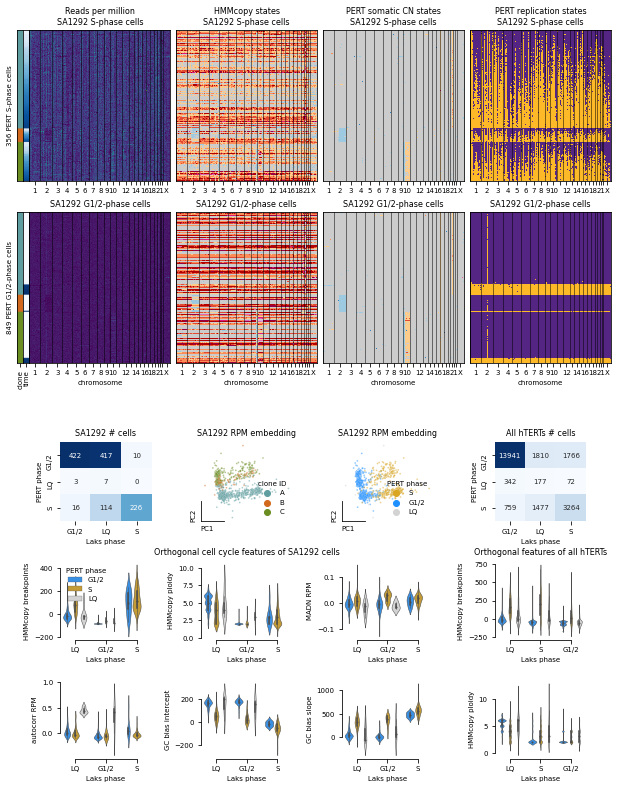

In [59]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
fig = plt.figure(figsize=(8.5, 11))

# create a grid of axes to plot the heatmaps
# 2 rows and 4 columns with 2 colorbars on the left for both rows
# top row will show S-phase cells
ax0 = fig.add_axes([0.03, 0.78, 0.01, 0.19])
ax1 = fig.add_axes([0.04, 0.78, 0.01, 0.19])
ax2 = fig.add_axes([0.05, 0.78, 0.23, 0.19])
ax3 = fig.add_axes([0.29, 0.78, 0.23, 0.19])
ax4 = fig.add_axes([0.53, 0.78, 0.23, 0.19])
ax5 = fig.add_axes([0.77, 0.78, 0.23, 0.19])

# bottom row will show G1/2-phase cells
ax6 = fig.add_axes([0.03, 0.55, 0.01, 0.19])
ax7 = fig.add_axes([0.04, 0.55, 0.01, 0.19])
ax8 = fig.add_axes([0.05, 0.55, 0.23, 0.19])
ax9 = fig.add_axes([0.29, 0.55, 0.23, 0.19])
ax10 = fig.add_axes([0.53, 0.55, 0.23, 0.19])
ax11 = fig.add_axes([0.77, 0.55, 0.23, 0.19])

# add a grid of smaller subplots to show confusion matrices and scatterplots
# 3 rows and 4 columns
# first row of the grid
ax12 = fig.add_axes([0.1, 0.35, 0.15, 0.1])
ax13 = fig.add_axes([0.33, 0.35, 0.15, 0.1])
ax14 = fig.add_axes([0.56, 0.35, 0.15, 0.1])
ax15 = fig.add_axes([0.81, 0.35, 0.15, 0.1])

# second row of the grid
ax16 = fig.add_axes([0.1, 0.2, 0.15, 0.1])
ax17 = fig.add_axes([0.33, 0.2, 0.15, 0.1])
ax18 = fig.add_axes([0.56, 0.2, 0.15, 0.1])
ax19 = fig.add_axes([0.81, 0.2, 0.15, 0.1])

# third row of the grid
ax20 = fig.add_axes([0.1, 0.05, 0.15, 0.1])
ax21 = fig.add_axes([0.33, 0.05, 0.15, 0.1])
ax22 = fig.add_axes([0.56, 0.05, 0.15, 0.1])
ax23 = fig.add_axes([0.81, 0.05, 0.15, 0.1])

chrom_labels_to_remove = ['11', '13', '15', '17', '19', '20', '22']

# plot the cell by loci heatmaps
plot_pert_cn_rep_heatmaps(
    cn_s, cn_g, 
    ax2, ax8, ax3, ax9,
    ax4, ax10, ax5, ax11,
    ax0, ax6, ax1, ax7,
    chrom_labels_to_remove=chrom_labels_to_remove
)

# plot the SA1292 confusion matrix in ax12
plot_confusion_matrix(df, ax12, dataset='SA1292')

# plot the SA1292 violin plots in the bottom left corner
plot_violin_plots(df, [ax16, ax17, ax18, ax20, ax21, ax22])

# plot the SA1292 RPM PCA embeddings ax13 and ax14
plot_rpm_pca_embeddings(pca_df, [ax13, ax14], dataset='SA1292')

# add the confusion matrix for all hTERT samples in ax15
plot_confusion_matrix(cohort_df, ax15, dataset='All hTERTs')

# show the othogonal features of all hTERTs in ax19 and ax23
plot_cohort_violin_plots(cohort_df, [ax19, ax23])

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# save the figure
fig.savefig('scdna_replication_paper/manuscript/supplementary_figs/figS3.pdf', dpi=300, bbox_inches='tight')

plt.show()